### *Dissecting the multicellular ecosystem of metastatic melanoma by single-cell RNA-seq* 

**Dataset**: GSE72056 (Tirosh et al., *Science* 2016)  
**Cells**: ~4,600 cells from 19 melanoma tumors

---

### Scientific Background

Tumors are complex ecosystems with spatiotemproal interactions between hetergenous cell types, including:
- **Malignant cells**: Cancer cells with genetic mutations
- **Immune cells**: T cells, B cells, macrophages, NK cells that infiltrate the tumor
- **Stromal cells**: Fibroblasts, endothelial cells that support tissue structure

Traditional bulk RNA-seq averages gene expression across millions of cells, masking:
- **Tumor heterogeneity**: Different cancer cell subpopulations with varying drug resistance
- **Immune cell diversity**: Different T cell states (exhausted vs. activated)
- **Cell-cell interactions**: How cancer cells evade immune surveillance

Single-cell approaches evaluate genetic and transcriptional features present in thousands of individual cells per tumor. Here they used single-cell RNA sequencing (RNA-seq) to examine heterogeneities in malignant and nonmalignant cell types and states and to infer their possible drivers and interrelationships in the complex tumor cellular ecosystem.

## 1. Setup and Data Loading

In [15]:
# The expression data is in the supplementary file, not in individual sample tables
# According to the metadata:
# - Row 1: Cell classification (malignant=2, non-malignant=1, unresolved=0)
# - Row 2: Cell type annotations (T-cells=1, B-cells=2, Macrophages=3, Endothelial=4, CAFs=5)
# - Remaining rows: Gene expression values

import urllib.request
import os
# Import libraries
import scanpy as sc
import pandas as pd
import numpy as np
from pathlib import Path
import warnings
warnings.filterwarnings("ignore") 

# Set ScanPy figure directory
sc.settings.figdir = Path('./figures/')  # Save figures here

# Set random seed for reproducibility
np.random.seed(42)

# Download the supplementary file
suppl_url = "ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE72nnn/GSE72056/suppl/GSE72056_melanoma_single_cell_revised_v2.txt.gz"
suppl_file = "./data/raw/GSE72056_melanoma_single_cell_revised_v2.txt.gz"

# Download if not already present
if not os.path.exists(suppl_file):
    print(f"Downloading supplementary file (~30 MB)...")
    urllib.request.urlretrieve(suppl_url, suppl_file)
    print(f"✓ Downloaded to {suppl_file}")
else:
    print(f"✓ File already exists: {suppl_file}")

# Load the expression matrix
print("\nLoading expression matrix...")
expr_df = pd.read_csv(suppl_file, sep='\t', index_col=0, compression='gzip')


print(f"\nExpression matrix (genes only):")
print(f"  Shape: {expr_df.shape}")
print(f"  Genes: {expr_df.shape[0]:,}")
print(f"  Cells: {expr_df.shape[1]:,}")

✓ File already exists: ./data/raw/GSE72056_melanoma_single_cell_revised_v2.txt.gz

Loading expression matrix...

Expression matrix (genes only):
  Shape: (23689, 4645)
  Genes: 23,689
  Cells: 4,645


In [16]:
# Extract metadata rows, transpose for AnnData format
metadata = expr_df.iloc[0:3, :].T
metadata.columns = ['Tumor', 'Malignant status', 'Cell Type']

# Extract expression matrix (genes only), transpose for AnnData format
expr_matrix = expr_df.iloc[3:, :].T

# Create AnnData object
# Transpose so cells are rows and genes are columns

# Map malignant status to descriptive labels
malignant_map = {
    2.: 'Malignant',
    1.: 'Non-malignant',
    0.: 'Unresolved'
}

# Map cell type annotations to descriptive labels
cell_type_map = {
    1.: 'T cells',
    2.: 'B cells',
    3.: 'Macrophages',
    4.: 'Endothelial',
    5.: 'CAFs',
    6.: 'NK cells',
    0.: 'Unknown'
}


metadata['Malignant status'] = metadata['Malignant status'].map(malignant_map).astype('category')
metadata['Cell Type'] = metadata['Cell Type'].map(cell_type_map).astype('category')
metadata['Tumor'] = metadata['Tumor'].astype('category')

adata = sc.AnnData(X=expr_matrix.values,
                   obs=metadata,
                   var=pd.DataFrame(index=expr_matrix.columns))
adata.var_names_make_unique()

print(f"\n✓ AnnData object created!")
print(f"  Cells: {adata.n_obs}")
print(f"  Genes: {adata.n_vars}")
print(f"\nMetadata columns: {list(adata.obs.columns)}")

crosstab = pd.crosstab(adata.obs['Malignant status'], adata.obs['Cell Type'], margins=True)
print(f"\nCell type vs Malignant status crosstab:")

print(f"\nUnique tumors in dataset:")
unique_tumors = sorted(adata.obs['Tumor'].unique())
print(f"  Total: {len(unique_tumors)}")



✓ AnnData object created!
  Cells: 4645
  Genes: 23686

Metadata columns: ['Tumor', 'Malignant status', 'Cell Type']

Cell type vs Malignant status crosstab:

Unique tumors in dataset:
  Total: 19


In [17]:
#Print obs data types
print("\nMetadata data types:")
print(adata.obs.dtypes)


Metadata data types:
Tumor               category
Malignant status    category
Cell Type           category
dtype: object


DATASET OVERVIEW

Dimensions: 4645 cells × 23686 genes

Cell metadata columns: ['Tumor', 'Malignant status', 'Cell Type']
Gene metadata columns: []

AnnData object structure:
AnnData object with n_obs × n_vars = 4645 × 23686
    obs: 'Tumor', 'Malignant status', 'Cell Type'


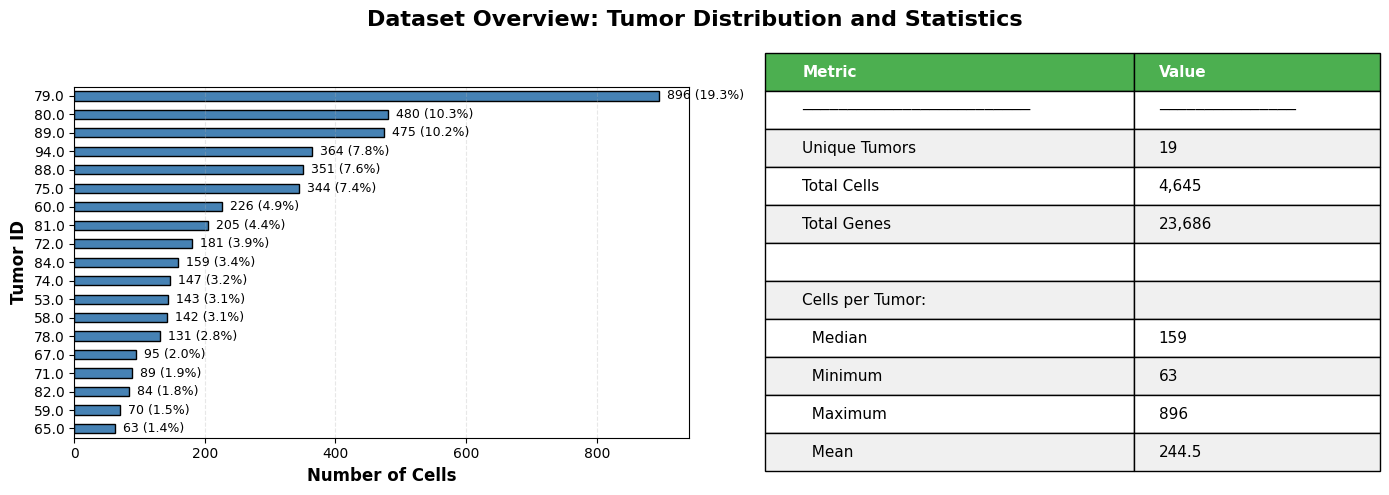

In [18]:
# Initial data inspection
print("="*80)
print("DATASET OVERVIEW")
print("="*80)
print(f"\nDimensions: {adata.n_obs} cells × {adata.n_vars} genes")
print(f"\nCell metadata columns: {list(adata.obs.columns)}")
print(f"Gene metadata columns: {list(adata.var.columns)}")

# Display the AnnData structure
print("\nAnnData object structure:")
print(adata)

# === 2. TUMOR DISTRIBUTION - Horizontal Bar Chart ===
import matplotlib.pyplot as plt

tumor_counts = adata.obs['Tumor'].value_counts().sort_values()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left panel: Horizontal bar chart sorted by count
tumor_counts.plot(kind='barh', ax=axes[0], color='steelblue', edgecolor='black')
axes[0].set_xlabel('Number of Cells', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Tumor ID', fontsize=12, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3, linestyle='--')

# Add count labels on bars
for i, (tumor, count) in enumerate(tumor_counts.items()):
    pct = count / adata.n_obs * 100
    axes[0].text(count, i, f'  {count} ({pct:.1f}%)', 
                va='center', fontsize=9)

# Right panel: Summary statistics table
stats_data = [
    ['Metric', 'Value'],
    ['─' * 25, '─' * 15],
    ['Unique Tumors', f"{adata.obs['Tumor'].nunique()}"],
    ['Total Cells', f"{adata.n_obs:,}"],
    ['Total Genes', f"{adata.n_vars:,}"],
    ['', ''],
    ['Cells per Tumor:', ''],
    ['  Median', f"{tumor_counts.median():.0f}"],
    ['  Minimum', f"{tumor_counts.min()}"],
    ['  Maximum', f"{tumor_counts.max()}"],
    ['  Mean', f"{tumor_counts.mean():.1f}"]
]

axes[1].axis('tight')
axes[1].axis('off')

table = axes[1].table(
    cellText=stats_data,
    cellLoc='left',
    loc='center',
    colWidths=[0.6, 0.4]
)

table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2.5)

# Style header row
for i in range(2):
    cell = table[(0, i)]
    cell.set_facecolor('#4CAF50')
    cell.set_text_props(weight='bold', color='white')

# Style data rows
for i in range(2, len(stats_data)):
    for j in range(2):
        cell = table[(i, j)]
        if i % 2 == 0:
            cell.set_facecolor('#f0f0f0')
        else:
            cell.set_facecolor('white')

plt.suptitle('Dataset Overview: Tumor Distribution and Statistics', 
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

Cell Type Distribution:
T cells                       :  2068 cells ( 44.5%)
Unknown                       :  1758 cells ( 37.8%)
B cells                       :   515 cells ( 11.1%)
Macrophages                   :   126 cells (  2.7%)
Endothelial                   :    65 cells (  1.4%)
CAFs                          :    61 cells (  1.3%)
NK cells                      :    52 cells (  1.1%)

Number of tumors: 19


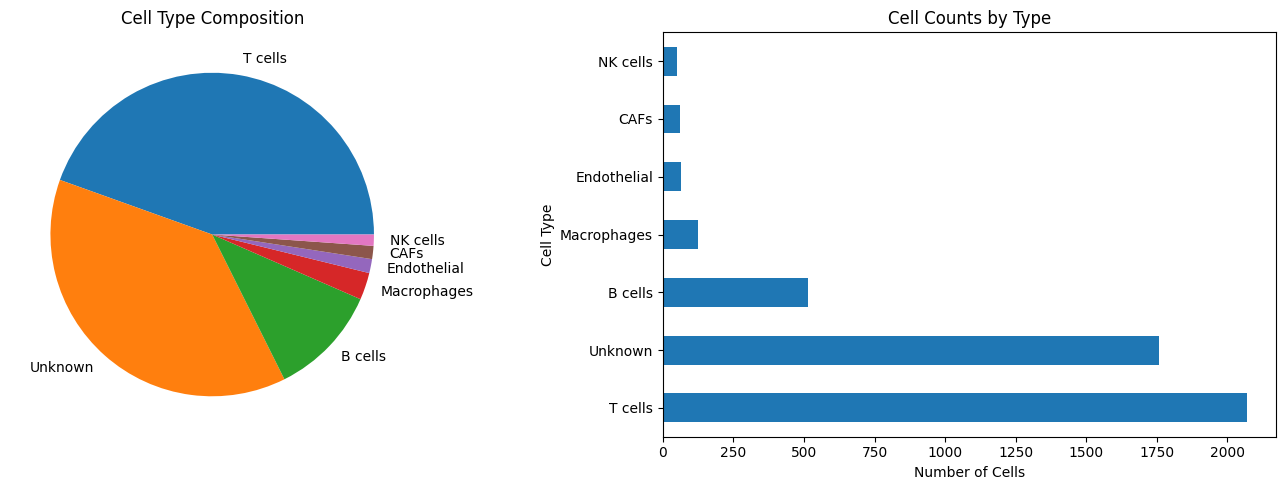

In [19]:
# Explore cell type composition (based on original annotations)
print("Cell Type Distribution:")
print("="*60)
cell_type_counts = adata.obs['Cell Type'].value_counts()
for cell_type, count in cell_type_counts.items():
    pct = count / adata.n_obs * 100
    print(f"{cell_type:30s}: {count:5d} cells ({pct:5.1f}%)")

print(f"\nNumber of tumors: {adata.obs['Tumor'].nunique()}")

# Close any existing figures
plt.close('all')

# Visualize cell type distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5), dpi=100)

# Pie chart
cell_type_counts.plot(kind='pie', ax=axes[0])
axes[0].set_ylabel('')
axes[0].set_title('Cell Type Composition')

# Bar chart
cell_type_counts.plot(kind='barh', ax=axes[1])
axes[1].set_xlabel('Number of Cells')
axes[1].set_title('Cell Counts by Type')

plt.tight_layout()
plt.show()


## 2. Quality Control (QC)

### Why QC is Critical
Low-quality cells can arise from:
- **Cell death**: Dying cells have broken membranes, leaking cytoplasm
- **Technical failures**: Poor encapsulation in droplets
- **Doublets**: Two cells captured together, appearing as artificial hybrid cells

### QC Metrics
1. **Total UMI counts** (library size): Too low = low-quality cell; too high = doublet
2. **Number of genes detected**: Healthy cells express 1,000-5,000 genes
3. **Mitochondrial gene %**: High (>20%) indicates cell death (damaged cells leak cytoplasm, enriching for mitochondria)

### Biological Context
- **UMI (Unique Molecular Identifier)**: Barcode added to each RNA molecule to count transcripts accurately
- **Mitochondrial genes**: Encoded in mitochondria (MT-); high % suggests cellular stress

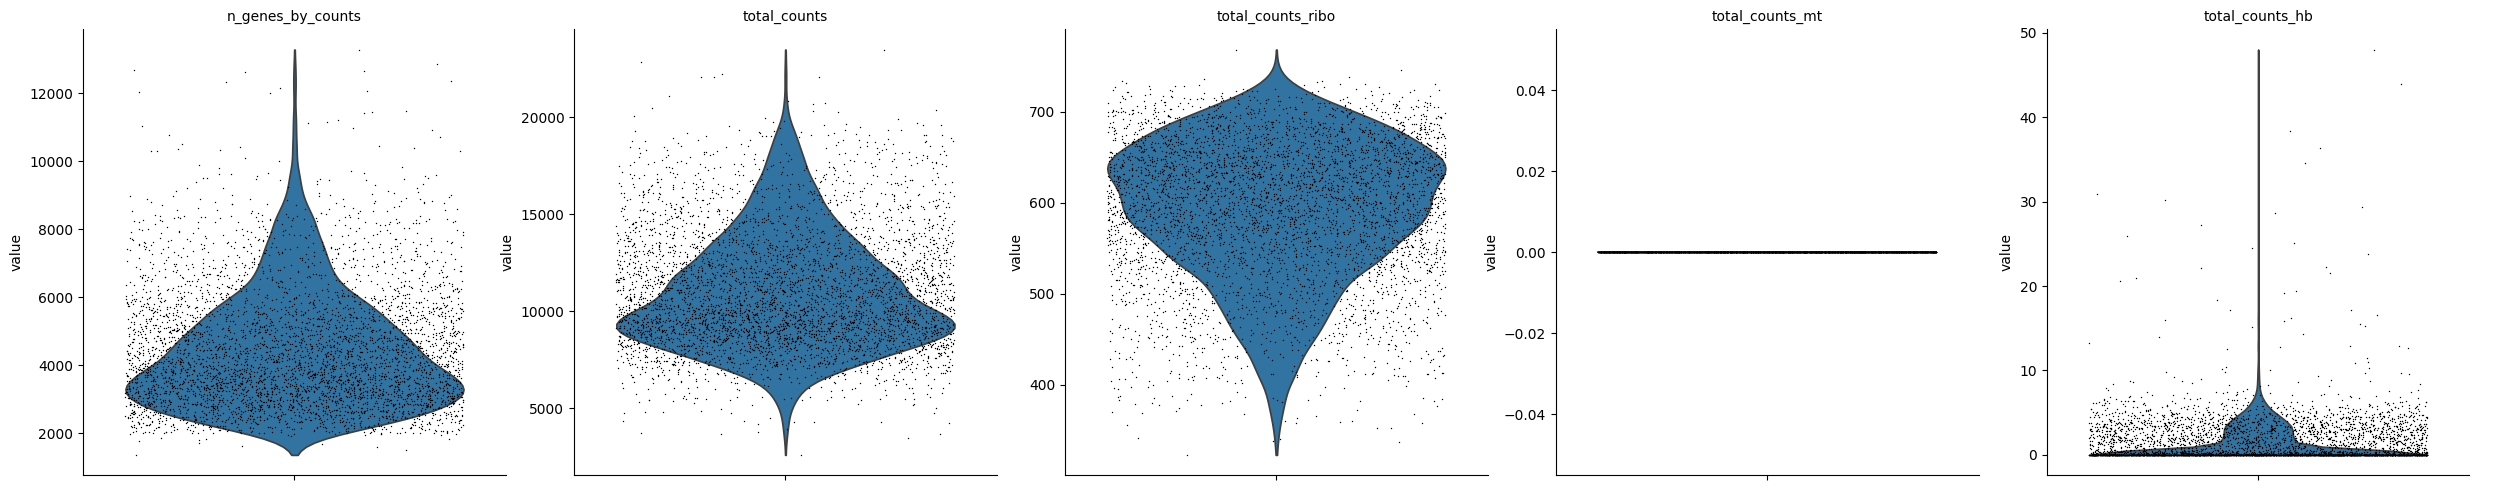

In [20]:
# Calculate QC metrics
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")


# Calculate QC metrics for each cell
sc.pp.calculate_qc_metrics(
    adata, 
    qc_vars=['mt', 'ribo', 'hb'],  # Track mitochondrial genes
    percent_top=None,  # Don't calculate top gene percentages
    log1p=True,  
    inplace=True  # Add to adata.obs
)
# Visualize QC metrics with violin plots

# Close any existing figures
plt.close('all')

sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "total_counts_ribo", "total_counts_mt", "total_counts_hb"],
    jitter=0.4,
    multi_panel=True,
)

In [21]:
# Filter cells based on QC metrics
print("Filtering cells based on QC metrics...")
print(f"Before filtering: {adata.n_obs} cells, {adata.n_vars} genes")


# Filter genes (keep genes expressed in at least 3 cells)
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)

print(f"After filtering:  {adata.n_obs} cells, {adata.n_vars} genes")
print(f"Removed: {4645 - adata.n_obs} cells")

# Store raw counts before normalization
adata.raw = adata.copy()
print("\n✓ Raw counts stored for later use (adata.raw)")

# Predict cell doublets using a nearest-neighbor classifier of observed transcriptomes and simulated doublets. 
sc.pp.scrublet(adata, batch_key="Tumor")

Filtering cells based on QC metrics...
Before filtering: 4645 cells, 23686 genes
After filtering:  4645 cells, 22289 genes
Removed: 0 cells

✓ Raw counts stored for later use (adata.raw)


## 3. Preprocessing and Normalization

### Why Normalize?
**Problem**: Different cells have different total UMI counts (library size) due to technical variation  
**Solution**: Normalize to make cells comparable

### Steps:
1. **Normalization**: Scale each cell to have the same total counts (e.g., 10,000)
   - Formula: `normalized = (counts / total_counts) × 10,000`
   - This is like converting counts to "counts per 10,000" (similar to CPM in bulk RNA-seq)

2. **Log transformation**: `log1p(x) = log(1 + x)`
   - Reduces skewness (RNA-seq data is highly skewed)
   - Stabilizes variance across expression levels
   - +1 prevents log(0) = -∞

3. **Highly Variable Genes (HVGs)**: Select genes with high biological variation
   - **Why?** Most genes are housekeeping genes with similar expression
   - **Goal**: Find genes that vary between cell types (e.g., immune markers)
   - **Method**: Calculate variance and select top ~2,000 genes
   - **Benefit**: Reduces noise and computational cost

In [22]:
adata.obs['Cell Type'].dtype

dtype('O')

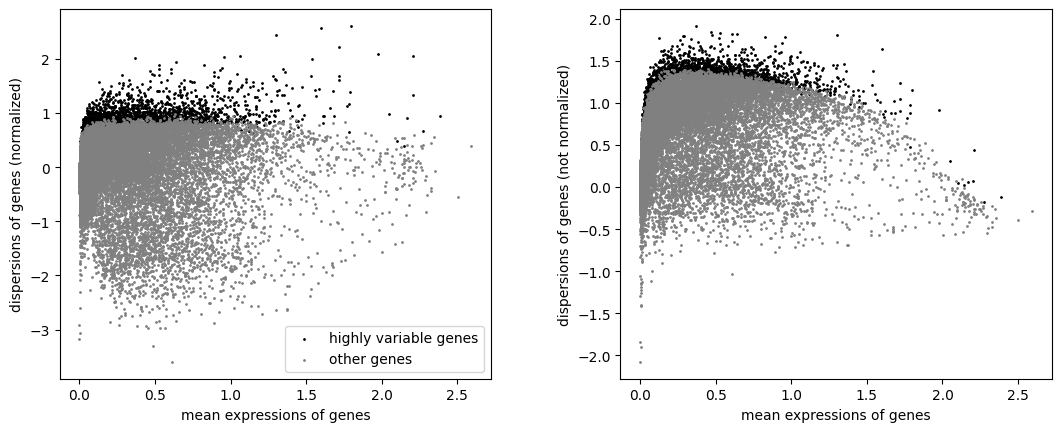

In [23]:
# Saving count data
adata.layers["counts"] = adata.X.copy()

# Normalizing to median total counts
sc.pp.normalize_total(adata)

# Logarithmize the data
sc.pp.log1p(adata)

# Convert Tumor column to categorical type
adata.obs["Tumor"] = adata.obs["Tumor"].astype('category')

# Identify highly variable genes
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key="Tumor")
sc.pl.highly_variable_genes(adata)

In [25]:
# Keep only highly variable genes for downstream analysis
# Note: adata.raw still contains all genes for later visualization
adata_hvg = adata[:, adata.var['highly_variable']].copy()

print(f"Dataset after HVG selection: {adata_hvg.n_obs} cells × {adata_hvg.n_vars} genes")
print(f"Reduced from {adata.n_vars} to {adata_hvg.n_vars} genes ({adata_hvg.n_vars/adata.n_vars*100:.1f}%)")

# Use HVG dataset for downstream analysis
adata = adata_hvg.copy()
del adata_hvg  # Free memory

Dataset after HVG selection: 4645 cells × 2000 genes
Reduced from 22289 to 2000 genes (9.0%)


In [26]:
# Scale data: zero mean and unit variance
# This ensures all genes contribute equally to PCA (prevents highly expressed genes from dominating)
sc.pp.scale(adata, max_value=10)  # Clip values at 10 std devs to reduce outlier effects

print("✓ Data scaling complete (zero-centered, unit variance, clipped at 10 SD)")
print("  - All genes now have mean ≈ 0 and std ≈ 1")
print("  - Ready for PCA!")

✓ Data scaling complete (zero-centered, unit variance, clipped at 10 SD)
  - All genes now have mean ≈ 0 and std ≈ 1
  - Ready for PCA!


## 4. Dimensionality Reduction

### The High-Dimensionality Problem
- We have ~2,000 genes (dimensions) per cell
- Impossible to visualize in 2D/3D
- Many dimensions are correlated or noisy

### Solution: Reduce to interpretable dimensions

#### 1. **PCA (Principal Component Analysis)**
- **What**: Finds new axes (principal components) that capture maximum variance
- **How**: Linear transformation of gene expression space
- **Output**: 50 PCs (typically), ranked by variance explained
- **Why first**: Fast, removes noise, captures main biological signals

#### 2. **UMAP (Uniform Manifold Approximation and Projection)**
- **What**: Projects cells into 2D while preserving local structure
- **How**: Graph-based algorithm that keeps similar cells close together
- **Why**: Better at separating distinct cell types than t-SNE
- **Best for**: Visualizing clusters and cell type relationships

#### 3. **t-SNE (t-Distributed Stochastic Neighbor Embedding)**
- **What**: Alternative 2D projection emphasizing local neighborhoods
- **How**: Probabilistic approach to preserve pairwise distances
- **Why**: Good at revealing fine structure within clusters
- **Note**: Distances between clusters are not meaningful!

### Key Concept
We typically use: **PCA → UMAP/t-SNE**  
PCA removes noise first, then UMAP/t-SNE visualizes in 2D

In [ ]:
# PCA: Principal Component Analysis
sc.tl.pca(adata)
print("✓ PCA computed")
print(f"  Shape: {adata.obsm['X_pca'].shape} (cells × PCs)")
print(f"  Variance explained by PC1: {adata.uns['pca']['variance_ratio'][0]*100:.1f}%")
print(f"  Variance explained by top 10 PCs: {adata.uns['pca']['variance_ratio'][:10].sum()*100:.1f}%")

✓ PCA computed
  Shape: (4645, 50) (cells × PCs)
  Variance explained by PC1: 5.9%
  Variance explained by top 10 PCs: 22.8%


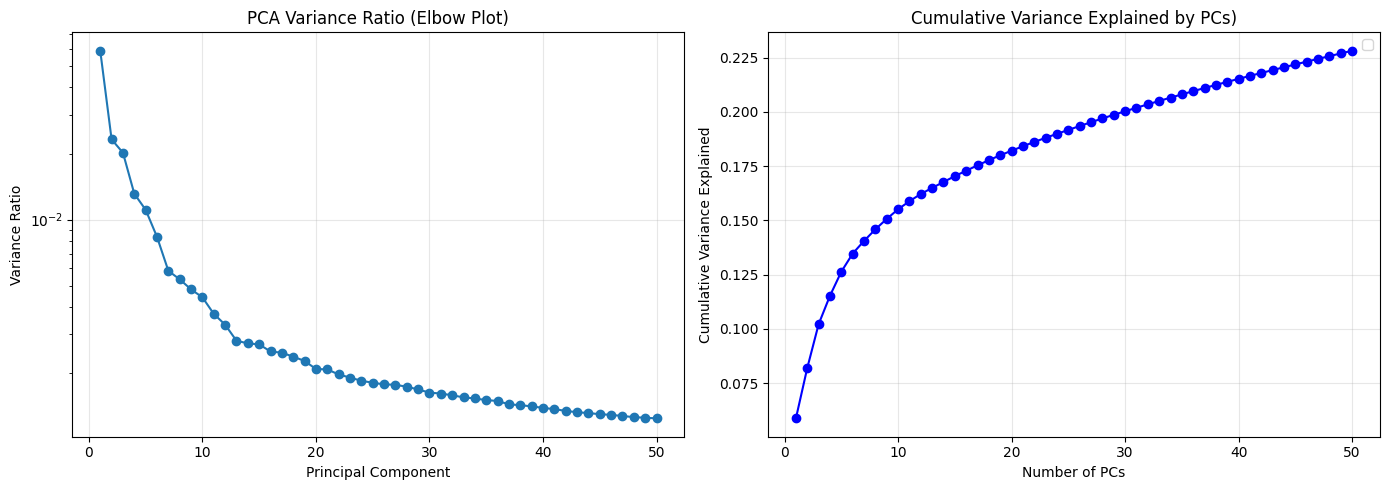


 PCA Variance Summary:
  • Top PC explains: 5.88%
  • Top 10 PCs explain: 15.51%


In [49]:
# Visualize PCA variance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Elbow plot - plot variance ratio manually
variance_ratio = adata.uns['pca']['variance_ratio']
axes[0].plot(range(1, len(variance_ratio[:50])+1), variance_ratio[:50], 'o-')
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Variance Ratio')
axes[0].set_yscale('log')
axes[0].set_title('PCA Variance Ratio (Elbow Plot)')
axes[0].grid(True, alpha=0.3)

# Cumulative variance
cumvar = np.cumsum(adata.uns['pca']['variance_ratio'])
axes[1].plot(range(1, len(cumvar)+1), cumvar, 'o-', color='blue')


axes[1].set_xlabel('Number of PCs')
axes[1].set_ylabel('Cumulative Variance Explained')
axes[1].set_title('Cumulative Variance Explained by PCs)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figures/03_pca_variance.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n PCA Variance Summary:")
print(f"  • Top PC explains: {variance_ratio[0]:.2%}")
print(f"  • Top 10 PCs explain: {cumvar[9]:.2%}")


plt.close('all')

In [31]:
# Compute neighborhood graph
# This finds the k-nearest neighbors for each cell in PC space
# Used by both UMAP and clustering algorithms
sc.pp.neighbors(
    adata,
    n_neighbors=15,  # Number of neighbors to consider
    n_pcs=40         # Use first 40 PCs
)

print("✓ Neighborhood graph computed (k=15 neighbors, 40 PCs)")

✓ Neighborhood graph computed (k=15 neighbors, 40 PCs)


In [32]:
# UMAP embedding
sc.tl.umap(adata)
print("✓ UMAP embedding computed")

# t-SNE embedding
sc.tl.tsne(adata, n_pcs=40)
print("✓ t-SNE embedding computed")

✓ UMAP embedding computed
✓ t-SNE embedding computed


## 5. Clustering and Cell Type Identification

### What is Clustering?
**Goal**: Group similar cells together without using prior knowledge  
**Method**: Graph-based clustering (Leiden algorithm)

### How Leiden Clustering Works
1. Cells are connected in a graph (k-nearest neighbors from PCA)
2. Algorithm finds communities (clusters) that are densely connected internally
3. **Resolution parameter**: Controls cluster granularity
   - Low resolution (e.g., 0.3): Fewer, larger clusters
   - High resolution (e.g., 1.0): More, smaller clusters

### Why Not Use Original Annotations?
The original paper already annotated cells, but we'll:
1. **Validate**: Check if our unsupervised clustering matches their annotations
2. **Learn**: Practice the workflow you'd use on new, unannotated data
3. **Discover**: Maybe find novel cell states they missed!

In [36]:
# Leiden clustering
sc.tl.leiden(
    adata,
    resolution=0.6,  # Try different values: 0.4 (coarse) to 1.0 (fine)
    random_state=42
)

print(f"✓ Leiden clustering complete (resolution=0.6)")
print(f"  Number of clusters: {adata.obs['leiden'].nunique()}")

# Show cluster sizes
cluster_counts = adata.obs['leiden'].value_counts().sort_index()
print("\nCluster sizes:")
for cluster, count in cluster_counts.items():
    pct = count / adata.n_obs * 100
    print(f"  Cluster {cluster}: {count:4d} cells ({pct:5.1f}%)")

✓ Leiden clustering complete (resolution=0.6)
  Number of clusters: 19

Cluster sizes:
  Cluster 0:  835 cells ( 18.0%)
  Cluster 1:  731 cells ( 15.7%)
  Cluster 2:  625 cells ( 13.5%)
  Cluster 3:  500 cells ( 10.8%)
  Cluster 4:  322 cells (  6.9%)
  Cluster 5:  268 cells (  5.8%)
  Cluster 6:  242 cells (  5.2%)
  Cluster 7:  203 cells (  4.4%)
  Cluster 8:  180 cells (  3.9%)
  Cluster 9:  159 cells (  3.4%)
  Cluster 10:  130 cells (  2.8%)
  Cluster 11:  129 cells (  2.8%)
  Cluster 12:   91 cells (  2.0%)
  Cluster 13:   61 cells (  1.3%)
  Cluster 14:   57 cells (  1.2%)
  Cluster 15:   36 cells (  0.8%)
  Cluster 16:   31 cells (  0.7%)
  Cluster 17:   26 cells (  0.6%)
  Cluster 18:   19 cells (  0.4%)


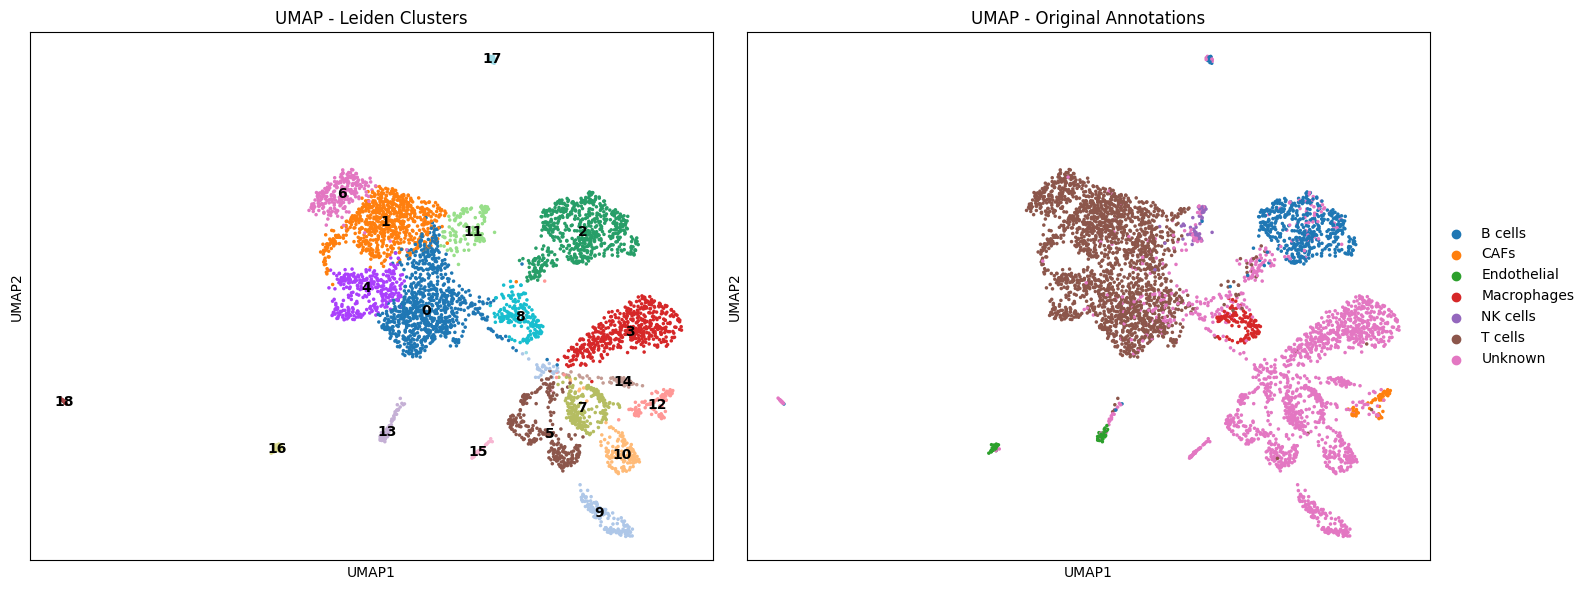


Compare the left (our clustering) vs right (original annotations)
Do they match? This validates our analysis!


In [38]:
# Visualize clusters
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sc.pl.umap(
    adata, 
    color='leiden',
    legend_loc='on data',
    legend_fontsize=10,
    ax=axes[0],
    show=False,
    title='UMAP - Leiden Clusters'
)

sc.pl.umap(
    adata,
    color='Cell Type',
    ax=axes[1],
    show=False,
    title='UMAP - Original Annotations'
)

plt.tight_layout()
plt.savefig('figures/06_leiden_clusters.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nCompare the left (our clustering) vs right (original annotations)")
print("Do they match? This validates our analysis!")

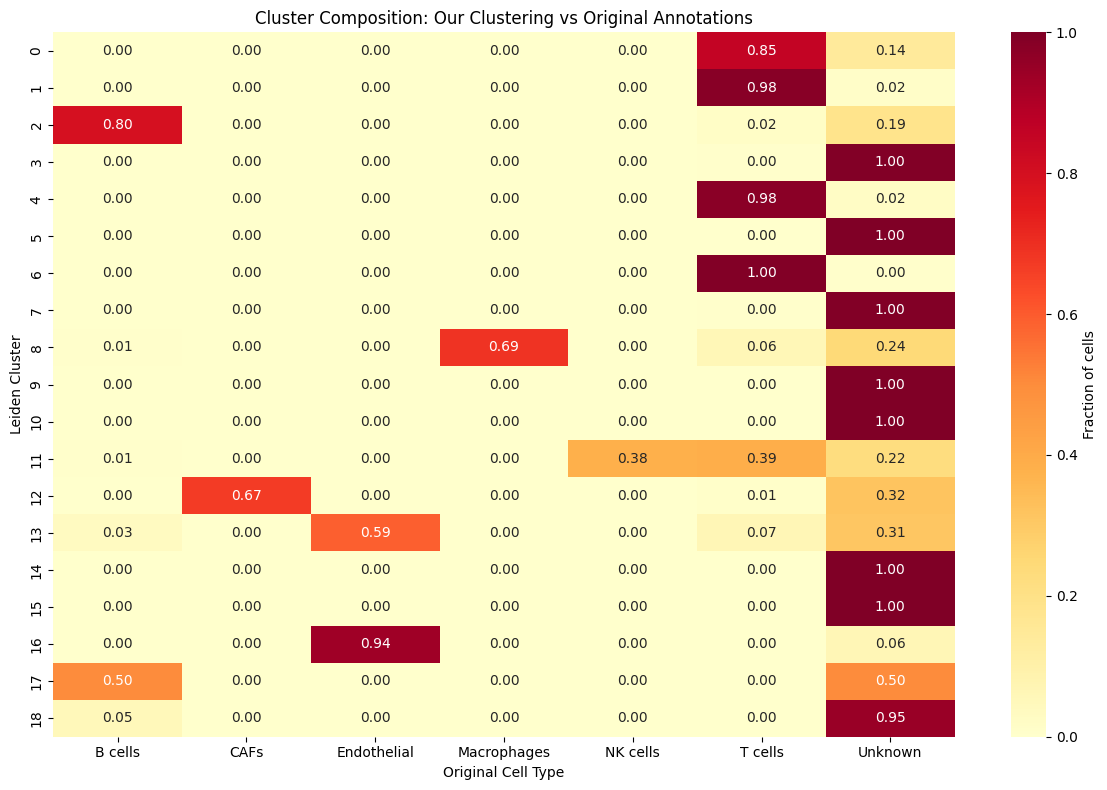


Interpretation:
Each row shows what % of cells in a cluster belong to each original cell type
Pure clusters (single cell type) validate our analysis
Mixed clusters might reveal new biology!


In [39]:
import seaborn as sns

# Compare our clusters to original cell type annotations
# Create a confusion matrix
cluster_celltype = pd.crosstab(
    adata.obs['leiden'], 
    adata.obs['Cell Type'],
    normalize='index'  # Show as percentages per cluster
)

plt.figure(figsize=(12, 8))
sns.heatmap(
    cluster_celltype,
    annot=True,
    fmt='.2f',
    cmap='YlOrRd',
    cbar_kws={'label': 'Fraction of cells'}
)
plt.xlabel('Original Cell Type')
plt.ylabel('Leiden Cluster')
plt.title('Cluster Composition: Our Clustering vs Original Annotations')
plt.tight_layout()
plt.savefig('figures/07_cluster_composition.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nInterpretation:")
print("Each row shows what % of cells in a cluster belong to each original cell type")
print("Pure clusters (single cell type) validate our analysis")
print("Mixed clusters might reveal new biology!")

## 6. Differential Expression and Marker Gene Identification

### What are Marker Genes?
**Definition**: Genes that are highly expressed in one cell type compared to others  
**Example**: CD3D is a T cell marker (high in T cells, low in others)

### Why Find Marker Genes?
1. **Annotate clusters**: Identify what cell type each cluster represents
2. **Validate biology**: Check if known markers appear in expected clusters
3. **Discover novel markers**: Find new genes that define cell states

### Statistical Test: Wilcoxon Rank-Sum Test
- **Null hypothesis**: Gene expression is the same in cluster A vs all other cells
- **Alternative**: Gene is differentially expressed (higher or lower)
- **Non-parametric**: Doesn't assume normal distribution (good for scRNA-seq)
- **Output**: 
  - **Score**: Log fold-change (logFC)
  - **p-value**: Significance (adjusted for multiple testing)

### Known Melanoma Markers
- **Malignant cells**: MITF, SOX10, MLANA, TYR (melanocyte/melanoma genes)
- **T cells**: CD3D, CD3E, CD8A (cytotoxic), CD4 (helper)
- **B cells**: CD79A, MS4A1 (CD20)
- **Macrophages**: CD68, CD14, CD163
- **NK cells**: NCAM1 (CD56), GNLY, NKG7
- **CAFs** (cancer-associated fibroblasts): COL1A1, FAP

In [40]:
# Find marker genes for each cluster
# This compares each cluster vs all other cells
sc.tl.rank_genes_groups(
    adata,
    groupby='leiden',
    method='wilcoxon',
    use_raw=True,  # Use raw counts (non-normalized) for statistical testing
    corr_method='benjamini-hochberg'  # Correct for multiple testing
)

print("✓ Differential expression analysis complete")
print("  Method: Wilcoxon rank-sum test")
print("  Comparison: Each cluster vs all other cells")
print("  Multiple testing correction: Benjamini-Hochberg (FDR)")

✓ Differential expression analysis complete
  Method: Wilcoxon rank-sum test
  Comparison: Each cluster vs all other cells
  Multiple testing correction: Benjamini-Hochberg (FDR)


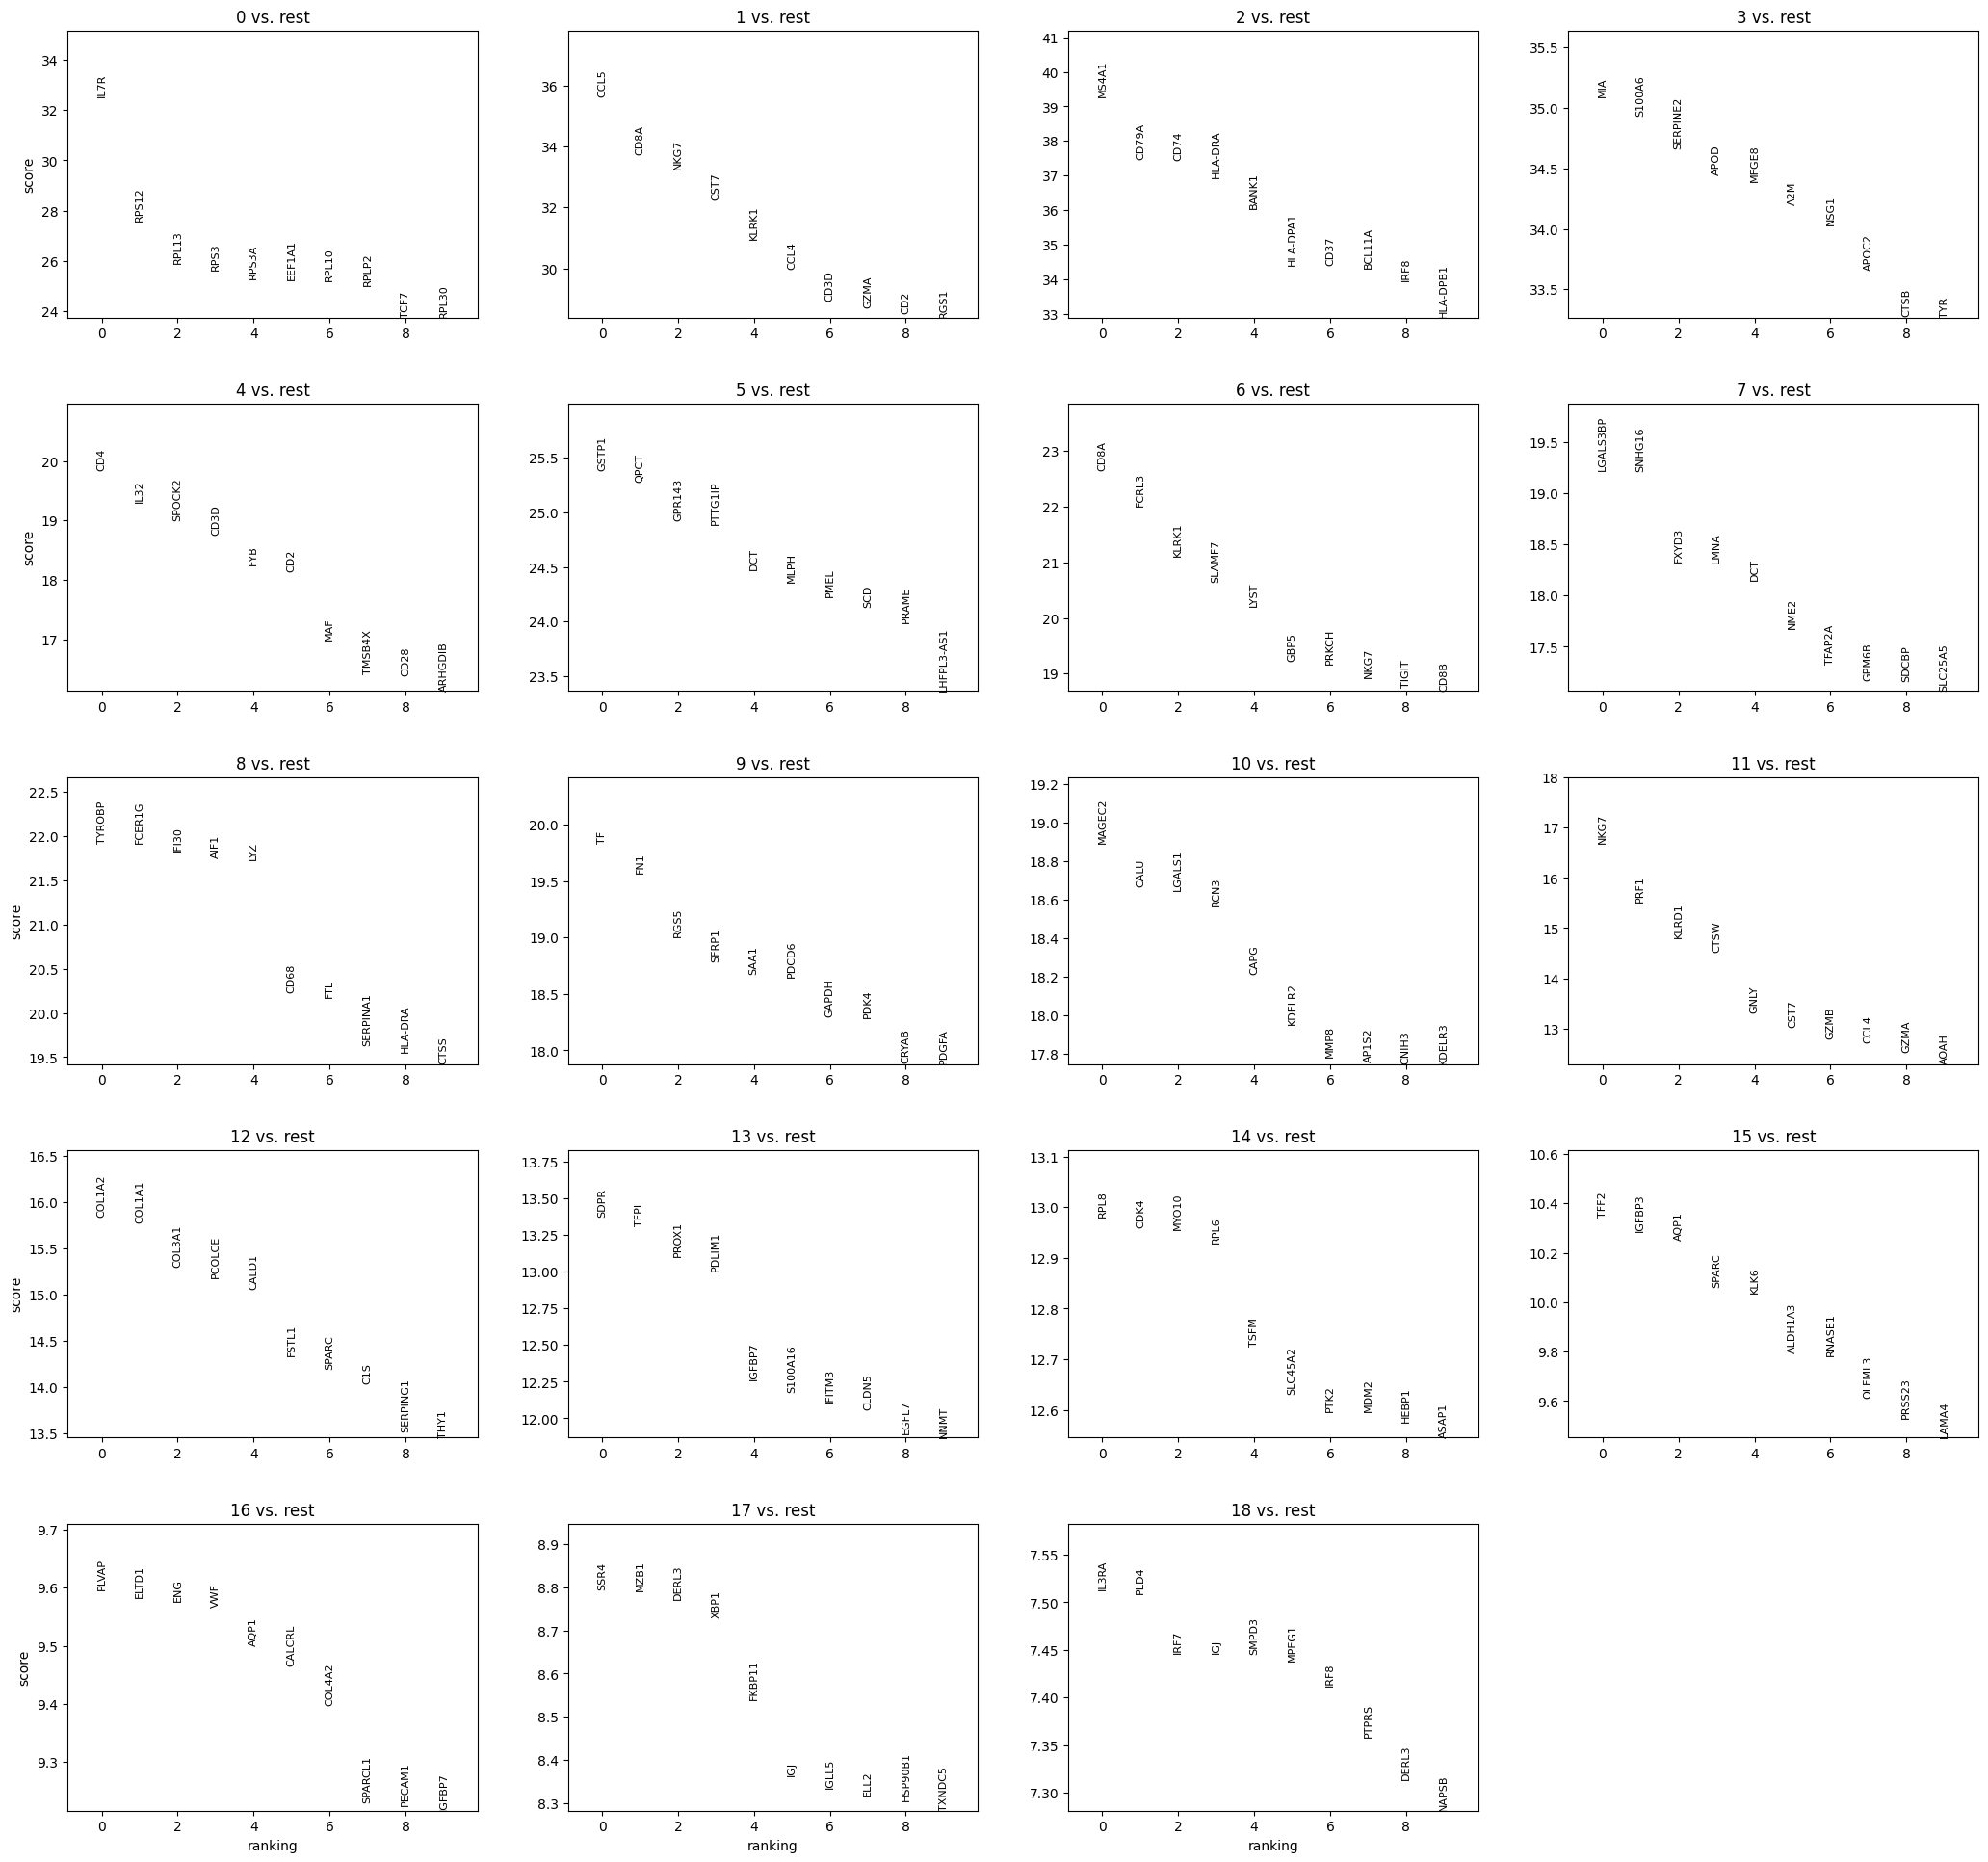


Top 5 marker genes per cluster:

Cluster 0:
  1. IL7R            (score:   32.5, p-adj: 9.02e-228)
  2. RPS12           (score:   27.6, p-adj: 2.46e-163)
  3. RPL13           (score:   25.9, p-adj: 3.88e-144)
  4. RPS3            (score:   25.6, p-adj: 3.94e-141)
  5. RPS3A           (score:   25.3, p-adj: 1.57e-137)

Cluster 1:
  1. CCL5            (score:   35.6, p-adj: 1.40e-273)
  2. CD8A            (score:   33.7, p-adj: 3.23e-245)
  3. NKG7            (score:   33.3, p-adj: 1.36e-238)
  4. CST7            (score:   32.2, p-adj: 2.04e-224)
  5. KLRK1           (score:   30.9, p-adj: 1.18e-206)

Cluster 2:
  1. MS4A1           (score:   39.3, p-adj: 0.00e+00)
  2. CD79A           (score:   37.5, p-adj: 3.78e-303)
  3. CD74            (score:   37.5, p-adj: 3.78e-303)
  4. HLA-DRA         (score:   37.0, p-adj: 3.57e-295)
  5. BANK1           (score:   36.1, p-adj: 4.10e-281)

Cluster 3:
  1. MIA             (score:   35.1, p-adj: 2.00e-265)
  2. S100A6          (score:   34.9, p-a

In [41]:
# Visualize top marker genes
sc.pl.rank_genes_groups(adata, n_genes=10, sharey=False, show=False)
plt.savefig('figures/08_marker_genes.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nTop 5 marker genes per cluster:")
print("="*80)
result = adata.uns['rank_genes_groups']
for cluster in result['names'].dtype.names:
    print(f"\nCluster {cluster}:")
    for i in range(5):
        gene = result['names'][cluster][i]
        score = result['scores'][cluster][i]
        pval = result['pvals_adj'][cluster][i]
        print(f"  {i+1}. {gene:15s} (score: {score:6.1f}, p-adj: {pval:.2e})")

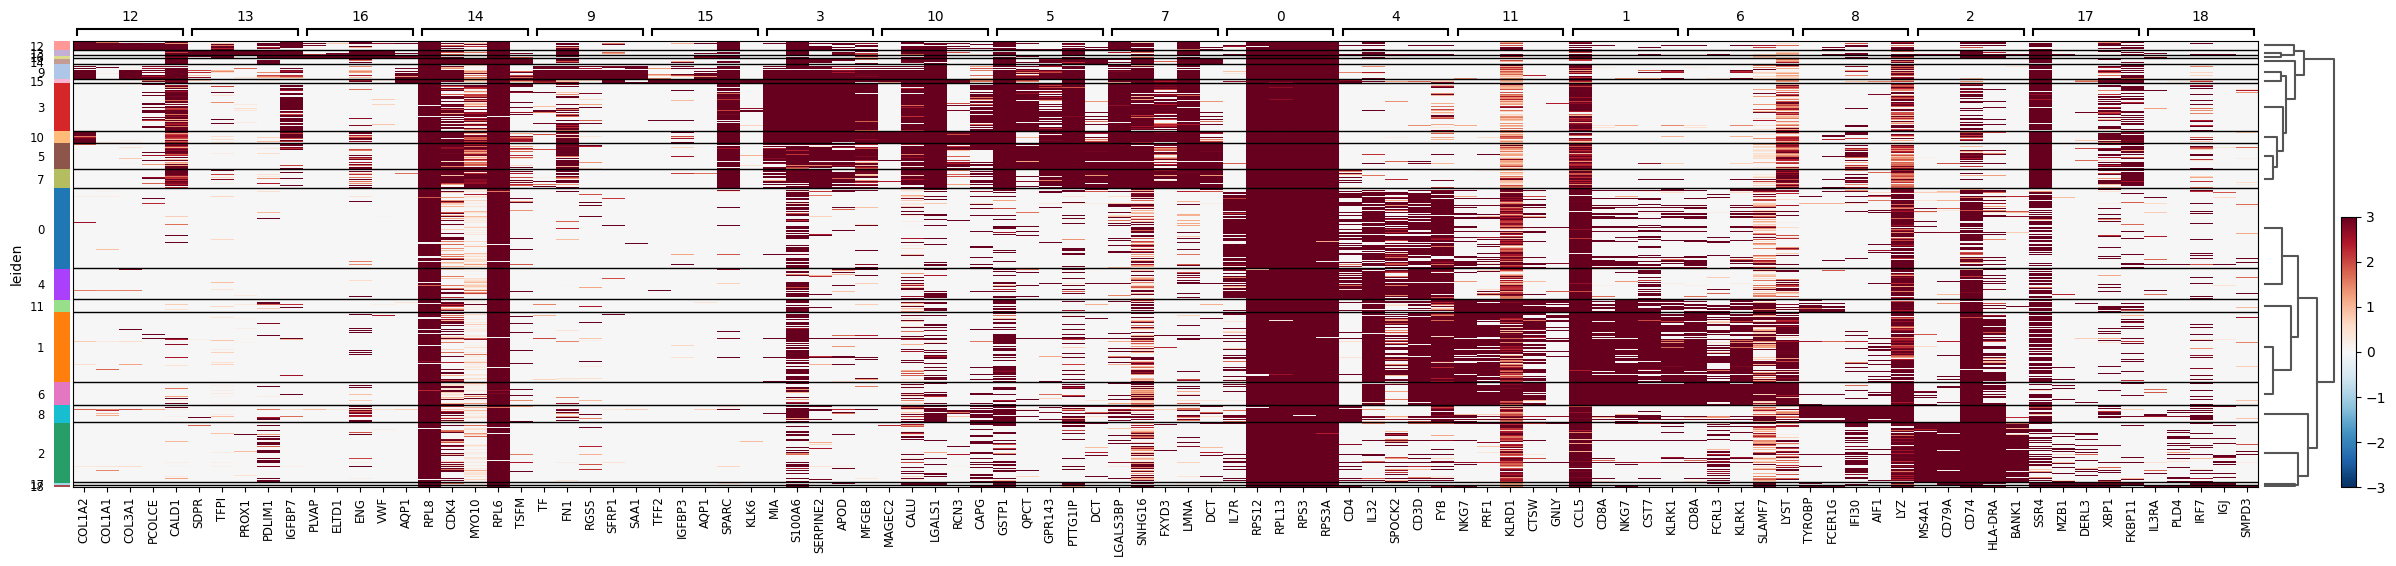

In [42]:
# Create a heatmap of top marker genes
sc.pl.rank_genes_groups_heatmap(
    adata,
    n_genes=5,
    groupby='leiden',
    show_gene_labels=True,
    use_raw=True,
    cmap='RdBu_r',
    vmin=-3,
    vmax=3,
    show=False
)
plt.savefig('figures/09_marker_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

In [43]:
# Visualize specific known marker genes
# This helps us annotate clusters

marker_genes = {
    'Malignant': ['MITF', 'SOX10', 'MLANA', 'TYR'],
    'T cells': ['CD3D', 'CD3E', 'CD8A', 'CD4'],
    'B cells': ['CD79A', 'MS4A1'],
    'Macrophages': ['CD68', 'CD14'],
    'NK cells': ['NCAM1', 'GNLY', 'NKG7'],
    'CAFs': ['COL1A1', 'FAP']
}

# Check which markers are present in our data
available_markers = {}
for cell_type, genes in marker_genes.items():
    available = [g for g in genes if g in adata.raw.var_names]
    if available:
        available_markers[cell_type] = available

print("Available marker genes in dataset:")
for cell_type, genes in available_markers.items():
    print(f"{cell_type}: {', '.join(genes)}")

Available marker genes in dataset:
Malignant: MITF, SOX10, MLANA, TYR
T cells: CD3D, CD3E, CD8A, CD4
B cells: CD79A, MS4A1
Macrophages: CD68, CD14
NK cells: NCAM1, GNLY, NKG7
CAFs: COL1A1, FAP


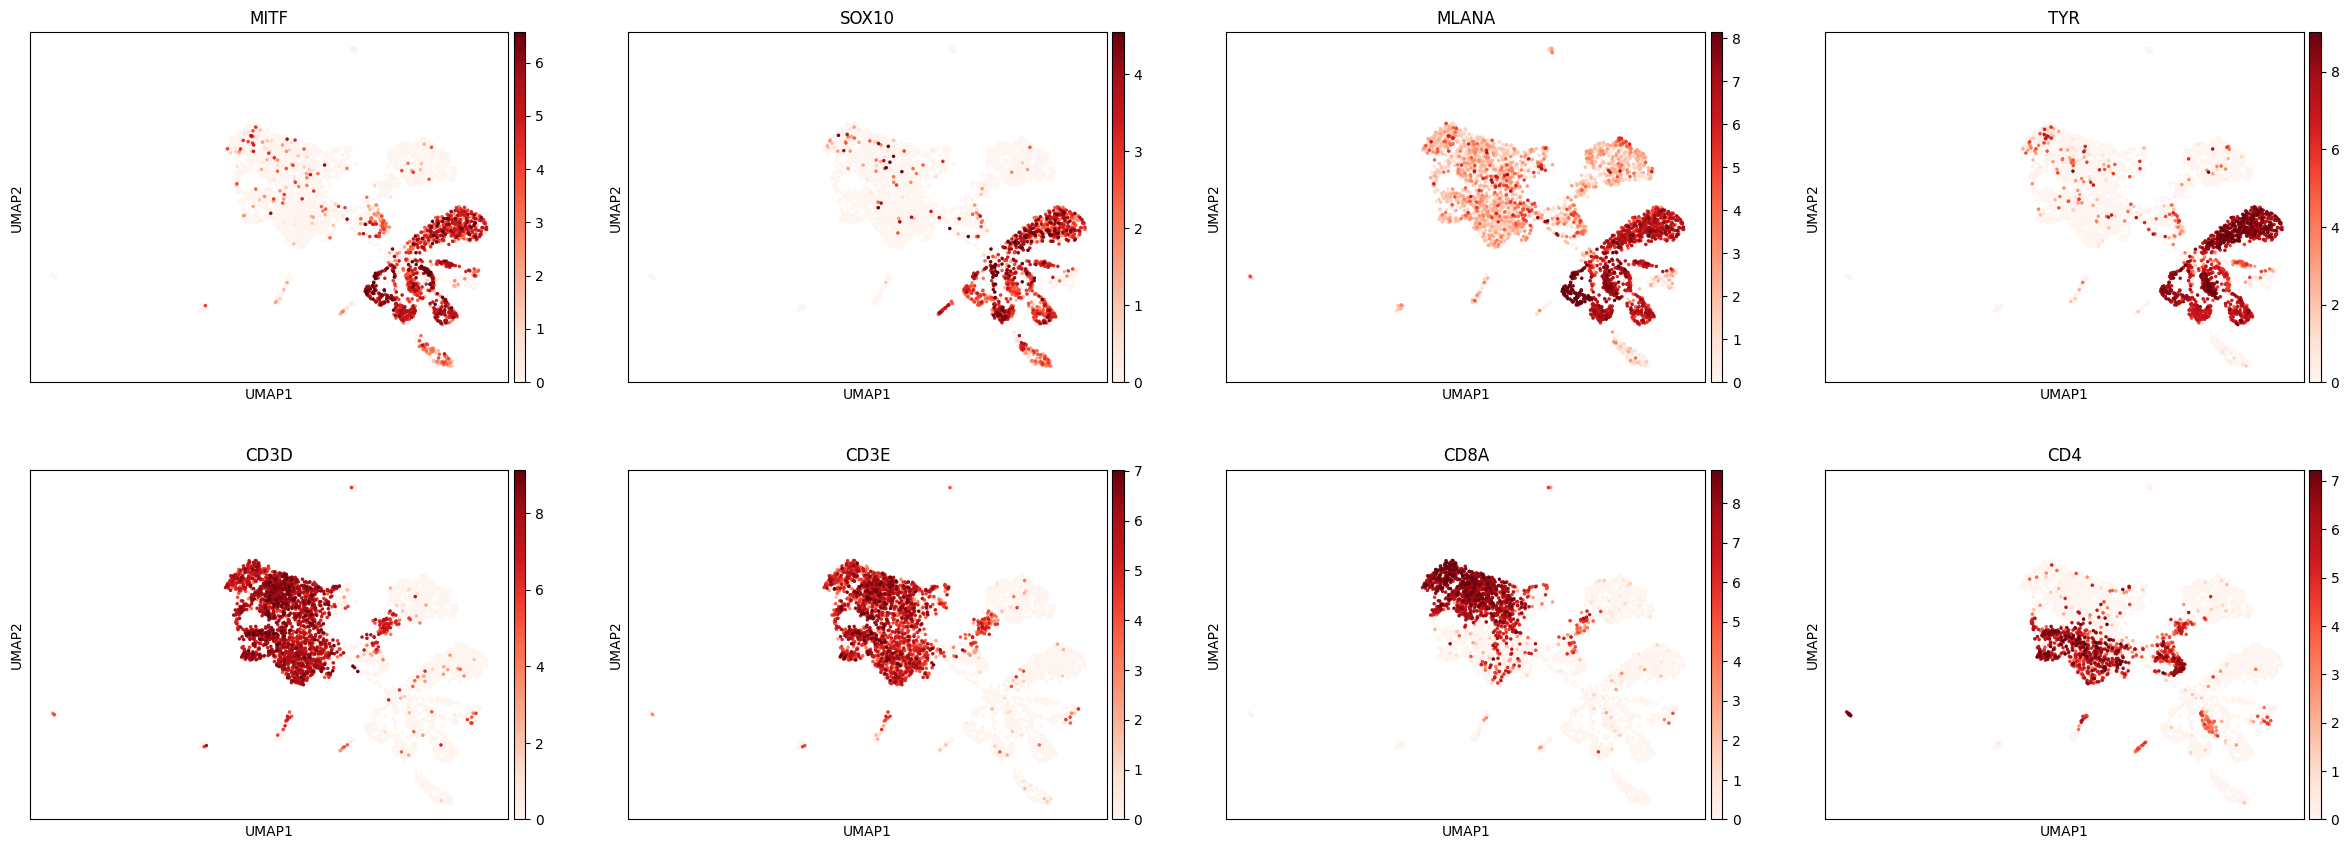


How to interpret:
- Red = high expression
- Blue/gray = low/no expression
- Look for clusters where specific markers are enriched


In [44]:
# Plot marker genes on UMAP
all_markers = [gene for genes in available_markers.values() for gene in genes]

sc.pl.umap(
    adata,
    color=all_markers[:8],  # Plot first 8 markers
    use_raw=True,
    ncols=4,
    vmax='p99',  # Set max to 99th percentile for better contrast
    cmap='Reds',
    show=False
)
plt.savefig('figures/10_marker_expression_umap.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nHow to interpret:")
print("- Red = high expression")
print("- Blue/gray = low/no expression")
print("- Look for clusters where specific markers are enriched")

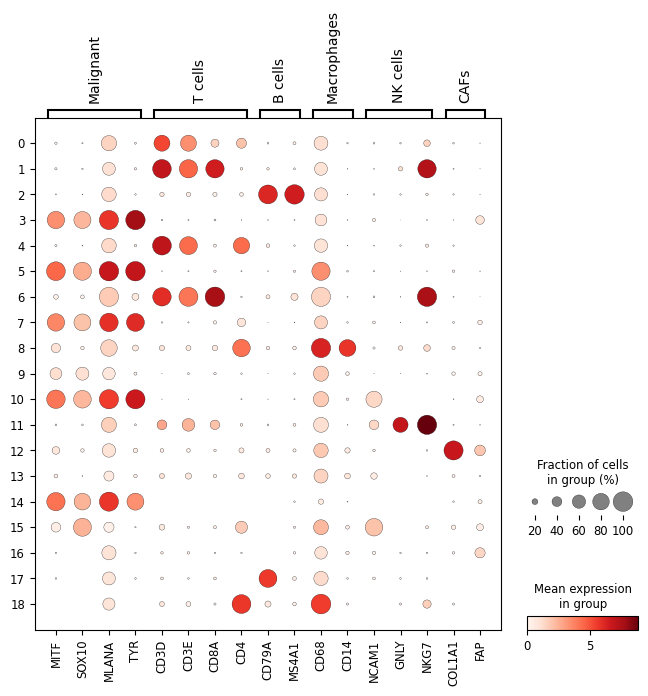


Dotplot interpretation:
- Dot size: % of cells in cluster expressing the gene
- Dot color: Average expression level (red = high)
- Use this to assign cell types to clusters!


In [45]:
# Dotplot: Shows both expression level and % of cells expressing
sc.pl.dotplot(
    adata,
    var_names=available_markers,
    groupby='leiden',
    use_raw=True,
    show=False
)
plt.savefig('figures/11_marker_dotplot.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nDotplot interpretation:")
print("- Dot size: % of cells in cluster expressing the gene")
print("- Dot color: Average expression level (red = high)")
print("- Use this to assign cell types to clusters!")